# ConvLSTM Time Series Forecasting

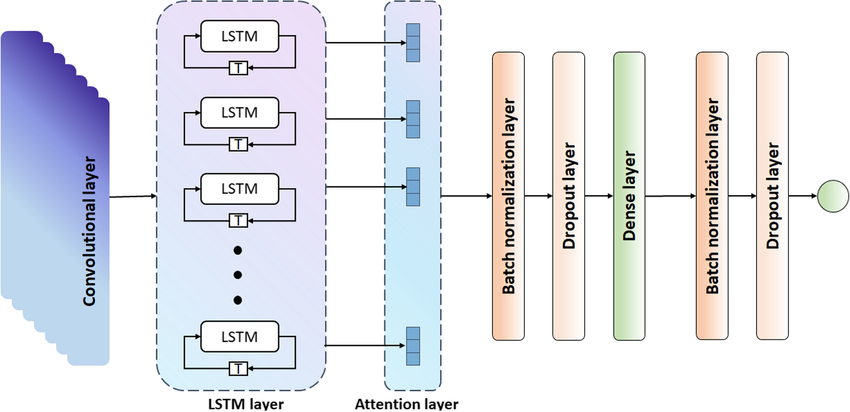

## Overview
This Notebook is based on a simplified modification of the techniques used in this [paper](https://www.researchgate.net/publication/359364499_A_novel_multi-step_forecasting_strategy_for_enhancing_deep_learning_models'_performance).
This notebook includes data preprocessing, model construction, advanced iterated forecasting, and insightful visualization for demonstrating this model.

## Key Highlights
-  How LSTMs can be used for Multivariate Time Series Data.
- Building, compiling, and training a ConvLSTM mode using TensorFlow and Keras.
- Explore iterated forecasting- where the model generates forecasts beyond the dataset's scope.
- Visualize results to gain insights into the model's performance.

## Requirements
Before we dive in, make sure you have the required libraries installed. You can install them using the following command:

```bash
!pip install tensorflow numpy pandas matplotlib scikit-learn
```


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_excel(r'AirQualityUCI.xlsx')
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


# PREPROCESSING AND CLEANING THE DATA
PLENTY OF VALUES ARE MARKED -200, POSSIBLY BECAUSE THEY ARE NOT RECORDED

In [6]:
df['NOx(GT)'].replace(-200,df['NOx(GT)'].mean(),inplace=True)
df['C6H6(GT)'].replace(-200,df['C6H6(GT)'].mean(),inplace=True)
df['T'].replace(-200,df['T'].mean(),inplace=True)
df['RH'].replace(-200,df['RH'].mean(),inplace=True)

# DEFINING MODEL

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense
from tensorflow.keras.models import Model

class ConvLSTM(Model):
    def __init__(self, time_steps, n_series):
        super(ConvLSTM, self).__init__()
        self.conv1d = Conv1D(32, kernel_size=2)
        self.lstm = LSTM(32)
        self.dense1 = Dense(32, activation='relu')
        self.dense2 = Dense(16, activation='relu')
        self.dense3 = Dense(n_series, activation='linear')

    def call(self, inputs):
        x = self.conv1d(inputs)
        x = self.lstm(x)
        x = self.dense1(x)
        x = self.dense2(x)
        outputs = self.dense3(x)
        return outputs

time_steps = 7
n_series = 3

inputs = Input(shape=(time_steps, n_series))
conv_lstm_model = ConvLSTM(time_steps, n_series)
outputs = conv_lstm_model(inputs)

conv_lstm_model.summary()


Model: "conv_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             multiple                  224       
                                                                 
 lstm (LSTM)                 multiple                  8320      
                                                                 
 dense (Dense)               multiple                  1056      
                                                                 
 dense_1 (Dense)             multiple                  528       
                                                                 
 dense_2 (Dense)             multiple                  51        
                                                                 
Total params: 10179 (39.76 KB)
Trainable params: 10179 (39.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# CONFIGURING INPUT TO THE MODEL
FOR TRAINING WE'LL TAKE ONLY 3 SERIES(FOR DEMONSTRATION)

We're creating input sequences and corresponding target values by taking slices of a normalized DataFrame, where each input sequence contains a sequence of time_steps consecutive rows and the corresponding target value is the row immediately following the sequence.







In [8]:
data=df[['T','RH','C6H6(GT)']]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

time_steps = 7
n_series = normalized_data.shape[1]  

input_sequences = []
target_values = []

## TAKING SLICES OF THE DATAFRAME SLICE(i, i+time_steps)
for i in range(len(normalized_data) - time_steps):
    input_sequences.append(normalized_data[i:i+time_steps])
    target_values.append(normalized_data[i+time_steps])

input_sequences = np.array(input_sequences)
target_values = np.array(target_values)

## SPLITTING THE DATA
split = int(0.8 * len(input_sequences))
x_train = input_sequences[:split]
y_train = target_values[:split]
x_test = input_sequences[split:]
y_test = target_values[split:]

inputs = Input(shape=(time_steps, n_series))
conv_lstm_model = ConvLSTM(time_steps, n_series)
outputs = conv_lstm_model(inputs)

# TRAINING MODEL

In [15]:
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=3e-4), loss='mean_squared_error')

history=model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=128, 
          validation_split=0.4, 
          )

predicted_values = model.predict(x_test)

predicted_values_original = scaler.inverse_transform(predicted_values)

Epoch 1/100
36/36 [==============================] - 1s 7ms/step - loss: 0.0697 - val_loss: 0.0933
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0691 - val_loss: 0.0946
Epoch 3/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0954
Epoch 4/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0917
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0684 - val_loss: 0.0945
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0694 - val_loss: 0.0976
Epoch 7/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0956
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0683 - val_loss: 0.0947
Epoch 9/100
36/36 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0946
Epoch 10/100
36/36 [==============================] - 0s 3ms/step - loss: 0.0684 - val_loss: 0.0962
Epoch 11/

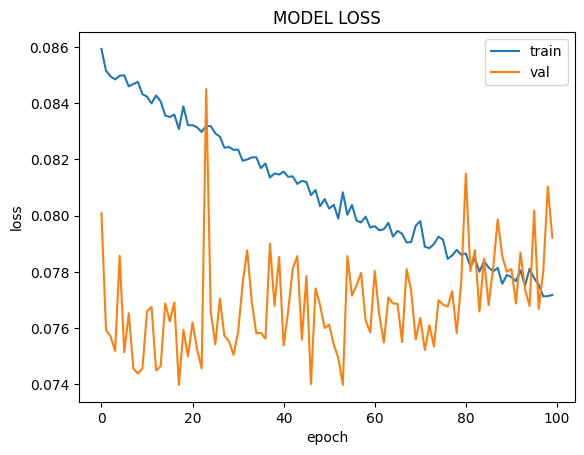

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# FORECASTING OUTSIDE THE SCOPE OF DATA

### THIS IS DONE USING ITERATED FORECASTING
Iterated forecasting is a method where a model's own predictions are used as inputs for generating future predictions, extending the forecasting horizon beyond the original data.

In [12]:
initial_input = input_sequences[-1] ## LAST INPUT SEQUENCE
num_iterations = 50
forecasts = []
for _ in range(num_iterations):
    forecast = model.predict(np.expand_dims(initial_input, axis=0))[0]
    forecast_original = scaler.inverse_transform(forecast.reshape(1, -1))
    forecasts.append(forecast_original[0])
    initial_input = np.concatenate((initial_input[1:], forecast.reshape(1, -1)), axis=0)

# print("Iterated Forecasts:")
# for i, forecast in enumerate(forecasts):
#     print(f"Iteration {i+1}: {forecast}")

1/1 [==============================] - 0s 8ms/step


### PLOTTING THE TAIL OF THE DATAFRAME

<Axes: >

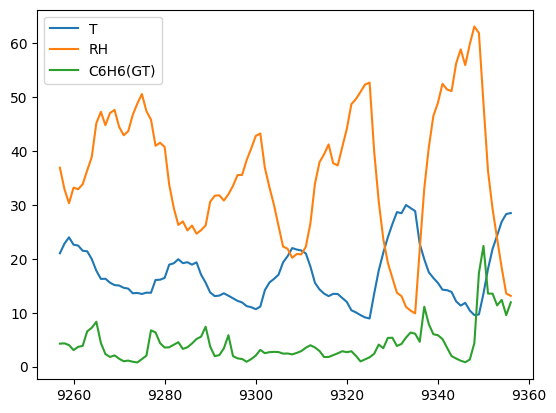

In [13]:
df[['T','RH','C6H6(GT)']][-100:].plot()

# FINAL FORECASTS

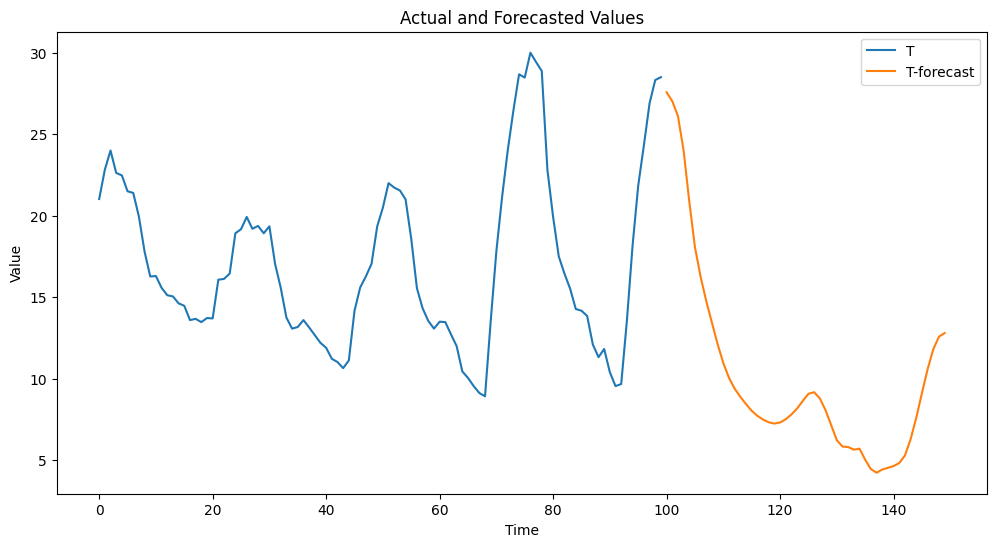

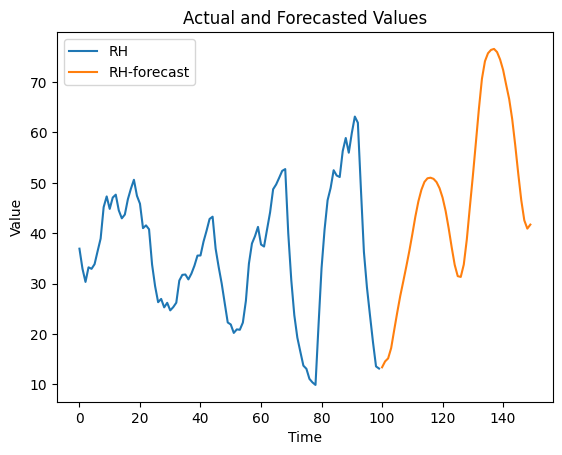

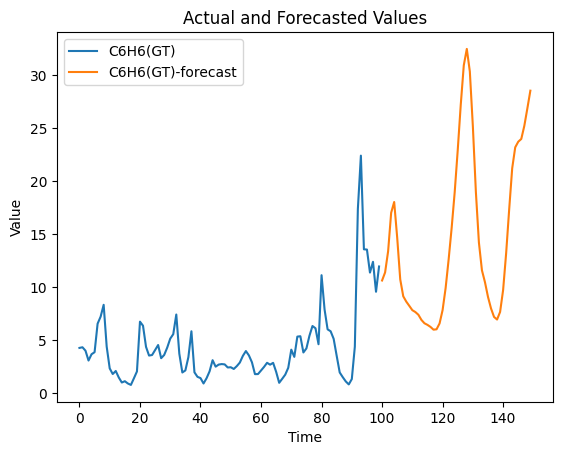

In [14]:
forecast_df = pd.DataFrame(forecasts, columns=data.columns)
tail_actual_df = data.tail(100)

combined_df = pd.concat([tail_actual_df, forecast_df])
combined_df=combined_df.reset_index()

plt.figure(figsize=(12, 6))
for column in data.columns:
    plt.plot(combined_df[:-num_iterations].index, combined_df[column][:-num_iterations], label=column)
    plt.plot(combined_df.index[-num_iterations:], combined_df[column][-num_iterations:], label=column + '-forecast')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Actual and Forecasted Values')
    plt.legend()
    plt.show()


#### FEEL FREE TO DROP IN YOUR REVIEWS IN THE COMMENTS